In [8]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

import pyarrow as pa
import pyarrow.dataset as ds

from torch.utils.data import DataLoader

from dataset import GeneIterableFixedB, split_filters_by_chroms
from model import PointerHead
from baseline_model import BaselinePointerHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PARQUET_DIR = "data/table"

CKPT_DIR = "results"
BASELINE_CKPT = os.path.join(CKPT_DIR, "final_baseline.pt")
HISTORY_CKPT  = os.path.join(CKPT_DIR, "final_his.pt")

TX_BATCH_SIZE = 8
PAD_BP = 5000

# bucket edges (bp) for suffix length
SUFFIX_BINS = [0, 4096, 6144, 8192, 10240, 12288, 14336, 16384, 24576, 32768, 65536, 10**9]
# bucket edges (num splice sites) for context length
CTX_BINS = [0, 2, 5, 9, 17, 10**9]

parquets = sorted(Path(PARQUET_DIR).glob("*.parquet"))
ONE_PARQUET = parquets[0]
print("Using:", ONE_PARQUET)

device: cuda
Using: data/table/ENCFF129ZDE.parquet


In [65]:
train_filter, val_filter, test_filter = split_filters_by_chroms()

test_dataset = GeneIterableFixedB(
    parquet_dir=PARQUET_DIR,
    split_filter=test_filter,
    tx_batch_size=TX_BATCH_SIZE,
    pad_bp=PAD_BP,
    shuffle=False,
)

test_dataset.parquet_paths = [ONE_PARQUET]
test_loader = DataLoader(test_dataset, batch_size=None)

In [66]:
def count_genes_transcripts_exons(parquet_dir, split_filter):
    dset = ds.dataset(str(parquet_dir), format="parquet")
    scanner = dset.scanner(filter=split_filter, columns=["gene_id", "transcripts"], use_threads=True, batch_size=128)
    reader = scanner.to_reader()

    gene_ids = set()
    n_transcripts = 0
    n_exons = 0

    for rb in reader:
        tbl = pa.Table.from_batches([rb])
        rows = tbl.to_pylist()
        for r in rows:
            gid = r.get("gene_id")
            if gid is not None:
                gene_ids.add(gid)

            txs = r.get("transcripts") or []
            # count all transcripts in the annotation
            n_transcripts += len(txs)

            for tx in txs:
                xs = tx.get("exon_starts") or []
                xe = tx.get("exon_ends") or []
                if len(xs) == 0 or len(xs) != len(xe):
                    continue
                n_exons += len(xs)

    return {
        "unique_genes": len(gene_ids),
        "num_transcripts_total": n_transcripts,
        "num_exons_total": n_exons,
        "avg_exons_per_transcript": (n_exons / max(n_transcripts, 1)),
    }

counts = count_genes_transcripts_exons(ONE_PARQUET, test_filter)
counts

{'unique_genes': 3161,
 'num_transcripts_total': 6224,
 'num_exons_total': 21517,
 'avg_exons_per_transcript': 3.4571015424164524}

In [ ]:
def bucketize(x, edges):
    idx = np.searchsorted(edges, x, side="right") - 1
    idx = np.clip(idx, 0, len(edges)-2)
    return idx

# always build hist counts (cheap)
ctx_hist = np.zeros(len(CTX_BINS)-1, dtype=np.int64)
suf_hist = np.zeros(len(SUFFIX_BINS)-1, dtype=np.int64)

n_batches = 0
n_examples = 0

for batch in test_loader:
    n_batches += 1
    cm = batch["context_mask"]  # (B,M) float32
    sm = batch["suffix_mask"]   # (B,S) float32

    ctx = cm.sum(dim=1).to(torch.int64).cpu().numpy()  # (B,)
    suf = sm.sum(dim=1).to(torch.int64).cpu().numpy()  # (B,)

    n_examples += ctx.size

    # hist buckets
    for v in ctx:
        ctx_hist[bucketize(v, CTX_BINS)] += 1
    for v in suf:
        suf_hist[bucketize(v, SUFFIX_BINS)] += 1

print("batches:", n_batches, "examples:", n_examples)

batches: 2177 examples: 34818


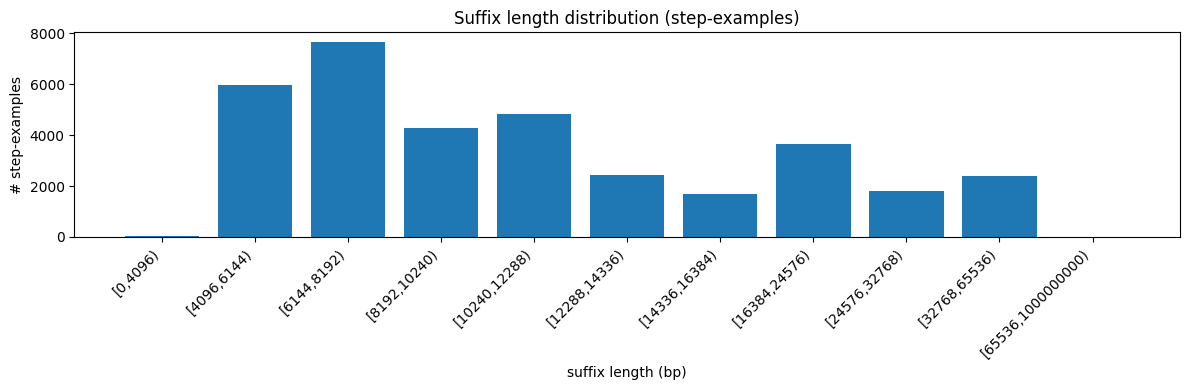

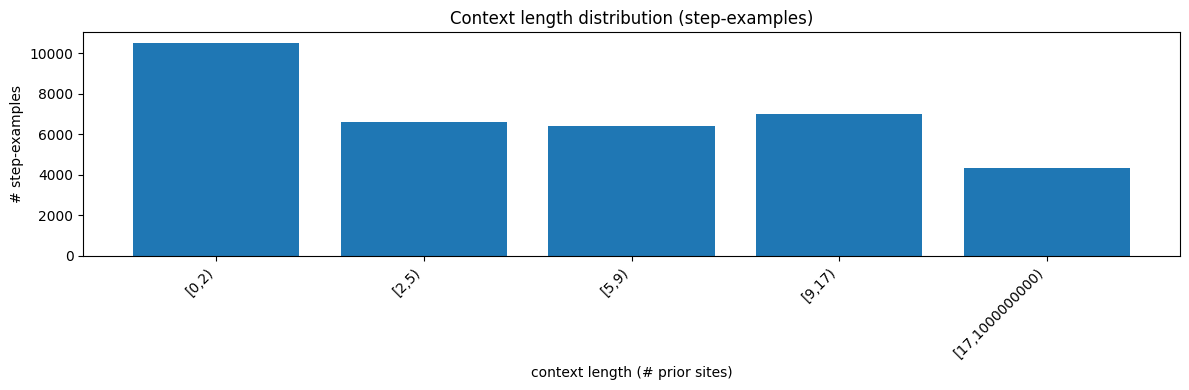

In [49]:
def plot_hist(counts, edges, title, xlabel):
    labels = [f"[{edges[i]},{edges[i+1]})" for i in range(len(edges)-1)]
    x = np.arange(len(labels))
    plt.figure(figsize=(12,4))
    plt.bar(x, counts)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("# step-examples")
    plt.tight_layout()
    plt.show()

plot_hist(suf_hist, SUFFIX_BINS, "Suffix length distribution (step-examples)", "suffix length (bp)")
plot_hist(ctx_hist, CTX_BINS, "Context length distribution (step-examples)", "context length (# prior sites)")

In [12]:
OUT_DIR = "analysis"

baseline_suf = pd.read_csv(os.path.join(OUT_DIR, "baseline_suffix_bins.csv"))
history_suf  = pd.read_csv(os.path.join(OUT_DIR, "history_suffix_bins.csv"))

baseline_ctx = pd.read_csv(os.path.join(OUT_DIR, "baseline_context_bins.csv"))
history_ctx  = pd.read_csv(os.path.join(OUT_DIR, "history_context_bins.csv"))

baseline_sum = pd.read_csv(os.path.join(OUT_DIR, "baseline_summary.csv"))
history_sum  = pd.read_csv(os.path.join(OUT_DIR, "history_summary.csv"))

baseline_role = pd.read_csv(os.path.join(OUT_DIR, "baseline_role_losses.csv"))
history_role  = pd.read_csv(os.path.join(OUT_DIR, "history_role_losses.csv"))

In [9]:
# Suffix
df_suf = baseline_suf.merge(
    history_suf, on="suffix_bin", suffixes=("_baseline", "_history")
)
df_suf["delta"] = df_suf["unweighted_mean_loss_history"] - df_suf["unweighted_mean_loss_baseline"]

# Context
df_ctx = baseline_ctx.merge(
    history_ctx, on="context_bin", suffixes=("_baseline", "_history")
)
df_ctx["delta"] = df_ctx["unweighted_mean_loss_history"] - df_ctx["unweighted_mean_loss_baseline"]

df_suf, df_ctx

(            suffix_bin  n_baseline  unweighted_mean_loss_baseline  n_history  \
 0             [0,4096)          43                       4.541731         43   
 1          [4096,6144)        5985                       4.847676       5985   
 2          [6144,8192)        7659                       3.750172       7659   
 3         [8192,10240)        4295                       3.519614       4295   
 4        [10240,12288)        4838                       3.483043       4838   
 5        [12288,14336)        2453                       4.348343       2453   
 6        [14336,16384)        1679                       4.994235       1679   
 7        [16384,24576)        3660                       5.266204       3660   
 8        [24576,32768)        1808                       5.380226       1808   
 9        [32768,65536)        2398                       6.457439       2398   
 10  [65536,1000000000)           0                       0.000000          0   
 
     unweighted_mean_loss_

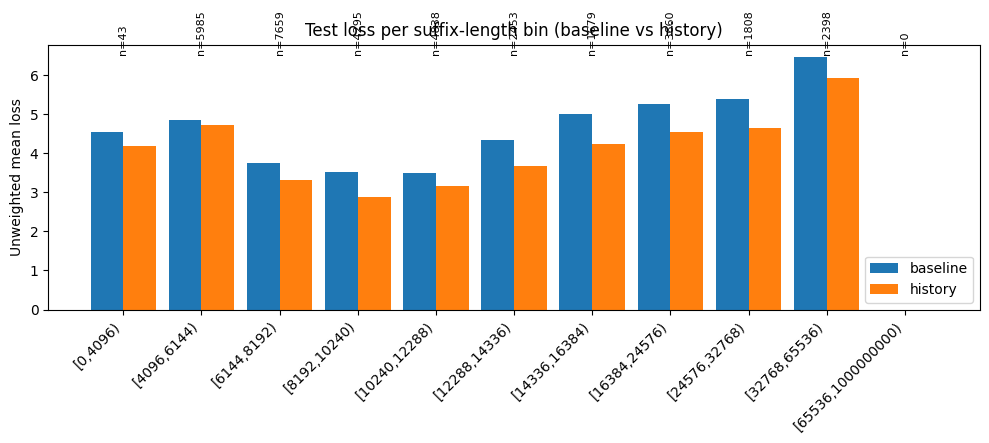

In [6]:
labels = df_suf["suffix_bin"].tolist()
x = np.arange(len(labels))
w = 0.42

plt.figure(figsize=(max(10, 0.9 * len(labels)), 4.5))
plt.bar(x - w/2, df_suf["unweighted_mean_loss_baseline"], width=w, label="baseline")
plt.bar(x + w/2, df_suf["unweighted_mean_loss_history"],  width=w, label="history")

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Unweighted mean loss")
plt.title("Test loss per suffix-length bin (baseline vs history)")
plt.legend()

# annotate counts (use baseline counts; should match history)
counts = df_suf["n_baseline"].to_numpy() if "n_baseline" in df_suf.columns else df_suf["n"].to_numpy()
ymax = max(df_suf["unweighted_mean_loss_baseline"].max(), df_suf["unweighted_mean_loss_history"].max())
for i, n in enumerate(counts):
    plt.text(i, ymax * 1.01, f"n={int(n)}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

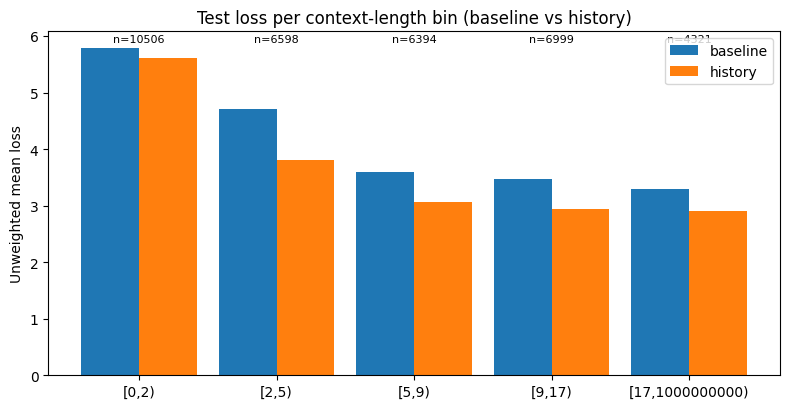

In [ ]:
labels = df_ctx["context_bin"].tolist()
x = np.arange(len(labels))
w = 0.42

plt.figure(figsize=(max(8, 1.0 * len(labels)), 4.2))
plt.bar(x - w/2, df_ctx["unweighted_mean_loss_baseline"], width=w, label="baseline")
plt.bar(x + w/2, df_ctx["unweighted_mean_loss_history"],  width=w, label="history")

plt.xticks(x, labels)
plt.ylabel("Unweighted mean loss")
plt.title("Test loss per context-length bin (baseline vs history)")
plt.legend()

counts = df_ctx["n_baseline"].to_numpy() if "n_baseline" in df_ctx.columns else df_ctx["n"].to_numpy()
ymax = max(df_ctx["unweighted_mean_loss_baseline"].max(), df_ctx["unweighted_mean_loss_history"].max())
for i, n in enumerate(counts):
    plt.text(i, ymax * 1.01, f"n={int(n)}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

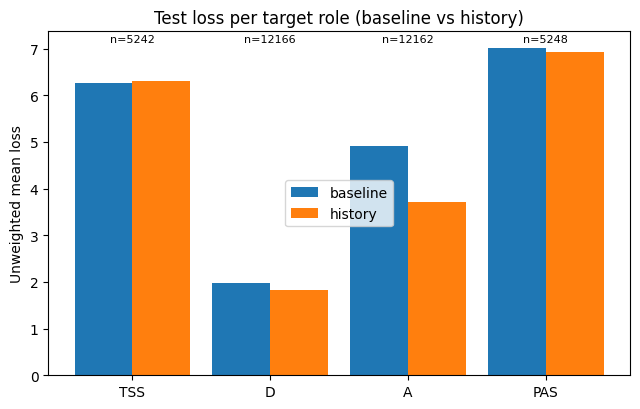

In [13]:
df_role = baseline_role.merge(
    history_role,
    on="target_role",
    suffixes=("_baseline", "_history")
)

labels = df_role["target_role"].tolist()
x = np.arange(len(labels))
w = 0.42

plt.figure(figsize=(6.5, 4.2))
plt.bar(x - w/2, df_role["unweighted_mean_loss_baseline"], width=w, label="baseline")
plt.bar(x + w/2, df_role["unweighted_mean_loss_history"],  width=w, label="history")

plt.xticks(x, labels)
plt.ylabel("Unweighted mean loss")
plt.title("Test loss per target role (baseline vs history)")
plt.legend()

ymax = max(df_role["unweighted_mean_loss_baseline"].max(), df_role["unweighted_mean_loss_history"].max())
for i, n in enumerate(df_role["n_baseline"].to_numpy()):
    plt.text(i, ymax * 1.01, f"n={int(n)}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()